<h1><center>Breast Tumour Classification Using Support Vector Machines</center></h1>


This project focuses on training an SVM classifier for breast tumour classification, using the famous Wisconsin Breast Cancer Dataset [1].


## Data

###Data Description

The data contains 569 samples and 32 feature columns, including mostly numeric features, which are quantitative characteristics of breast tumours discovered in patients, as well as a categorical variable **id**, containing patient id, as well as a binary variable **diagnosis**, with values "B" and "M", denoting *benign* and *malignant* tumours, respectively. [1] 

In this project we will consider **diagnosis** as a **target variable** and we will train an SVM classifier, in order to classify tumour samples as malignant or benign.

For the sake of brevity we will not elaborate further on the description of each one of the numeric feature variables, but a detailed description can be found in the source. [1]

### Data Quality

The quality of the dataset is good, there are no missing values in any of the variables and all the feature values are in a format which can directly be used by the SVM algorithm we are intending to use, hence we will not investigate further the data quality or engage in data processing.

### Data Loading


In [27]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sys
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [29]:
# Load Data
df = pd.read_csv("/content/gdrive/My Drive/MLProjects/WisconsinBreastCancerClassifier/wisconsin_breast_cancer_dataset.csv")
# remove 'Unnamed' columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.shape)
df.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Exploratory Data Analysis

### Balance of Dataset Labels

The first thing which is worth investigating is whether the number of samples with diagnosis "B" (benign tumour) is roughly equal to the number of samples with diagnosis "M" (malignant tumour).

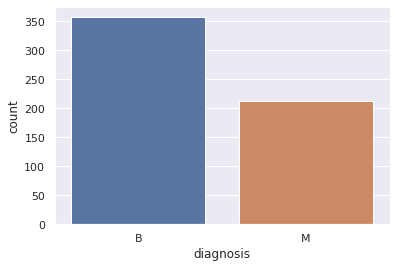

In [30]:
# check numbers of samples in both conditions (B and M), to see if they are balanced
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="diagnosis", data=df, order = ["B", "M"])

As one can see, the samples are not equally distributed between the two diagnoses (B nd M), there are rougly 1.7 times more samples with benign (B) tumours, than there are with malignant (M) tumours. Hence, when splitting the dataset into train and test set, we need to make sure that the proportion of the two labels is roughly the same in both train and test set.

### Check Variable Types

The next thing worth doing is once again looking at the type of the variables, which would help us later on decide on things like normalization, etc.

In [31]:
# check data types
print(df.dtypes)

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

It is also worth generating a numerical summary for each of the available variables, in order to obtain useful information such as mean and std, as well as finding out whether the variables are standardized. Normalizing numerical variables is important, as this could negatively affect the performance of some classifiers.

### Numerical Summary of Features

In [32]:
# summary of variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


As one can see, the features have different scales. This could potentially influence negatively the performance of some classifiers, hence, it is necessary to take care of this by transforming the data. This can be done by standardization or normalization. Standardizing the data is based on the assumption that the variables are normally distributed. Further down we generate histograms, in order to investigate whether this assumption is reasonable, and thus decide whether to standardize or normalize the data.

Another useful thing to do is check correlation between variables. This could potentially give us some ideas of how to simply our feature set and thus our model, in case of very strongly correlated variables.

### Check Correlation of Feature Variables

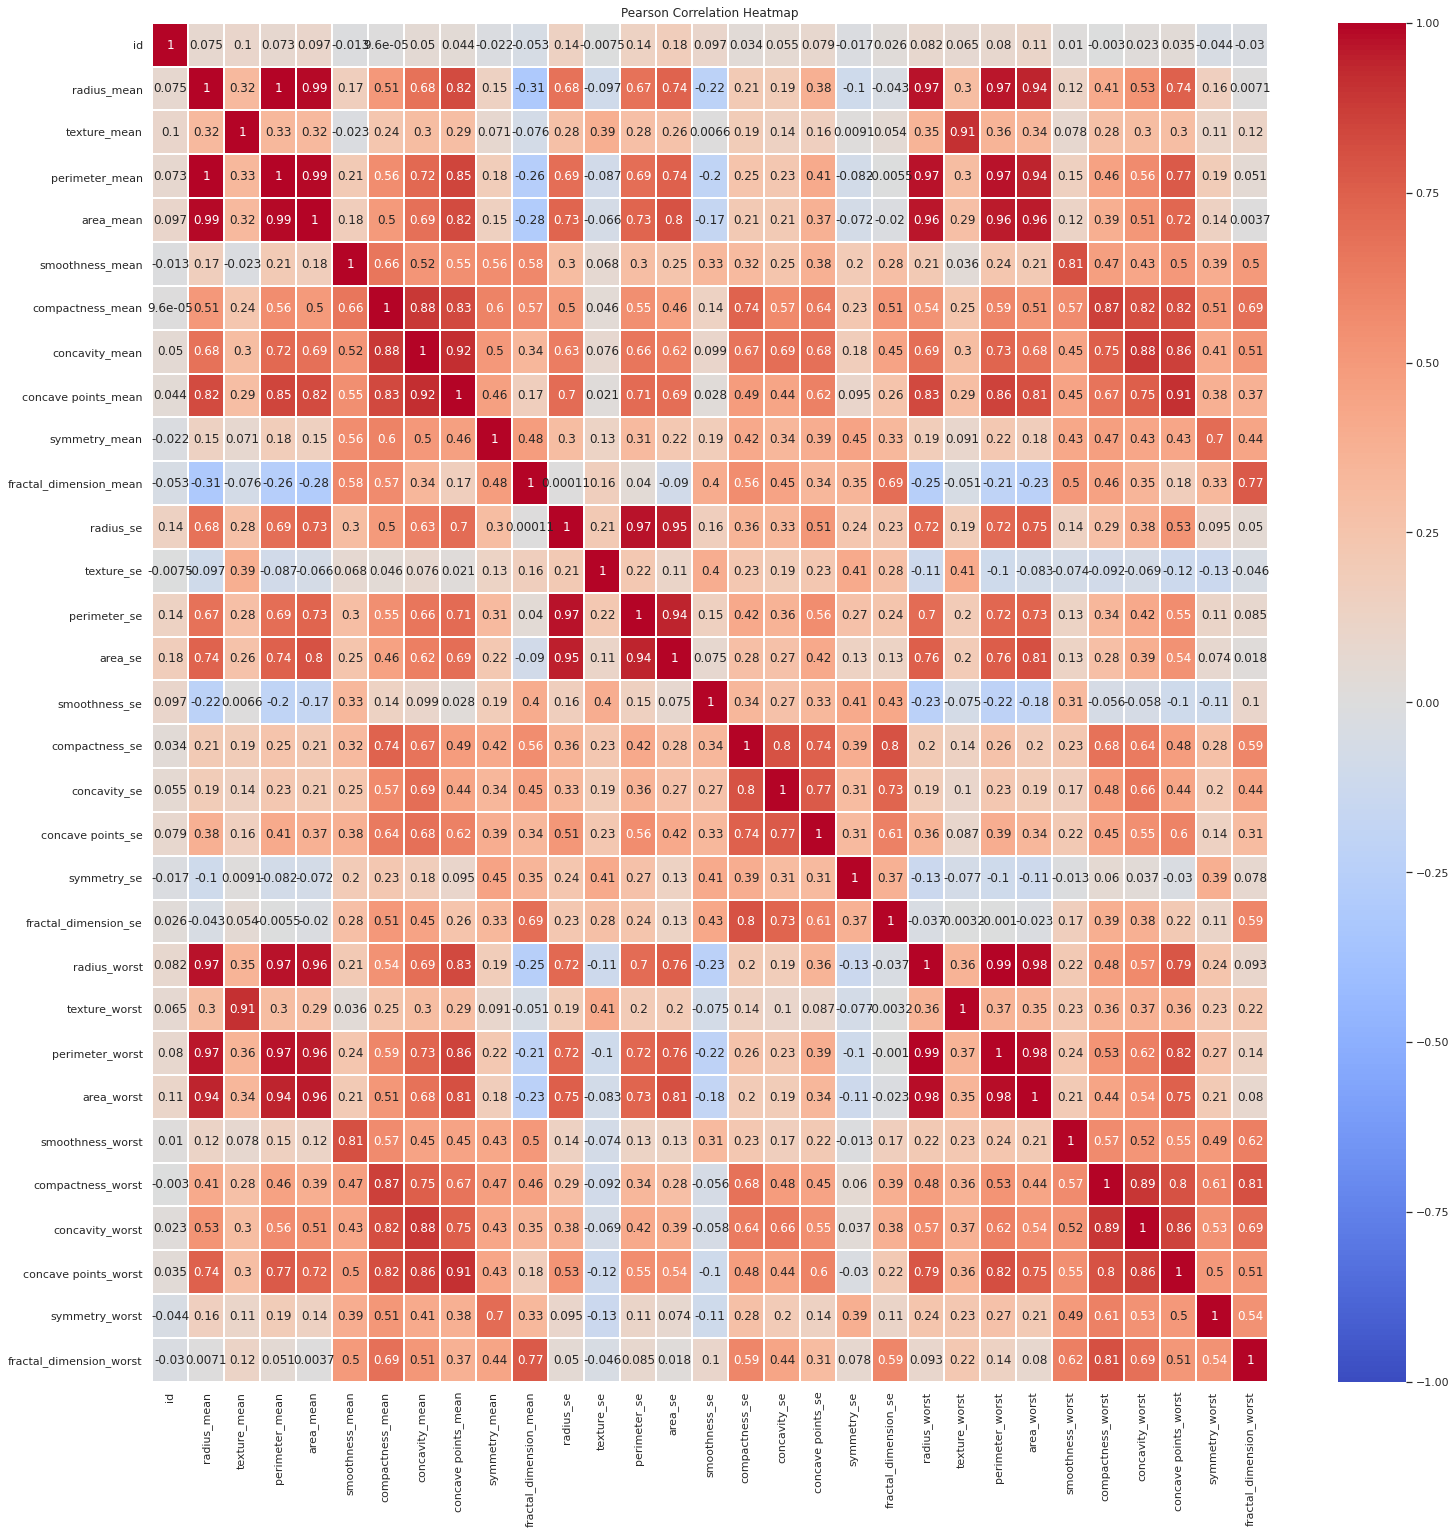

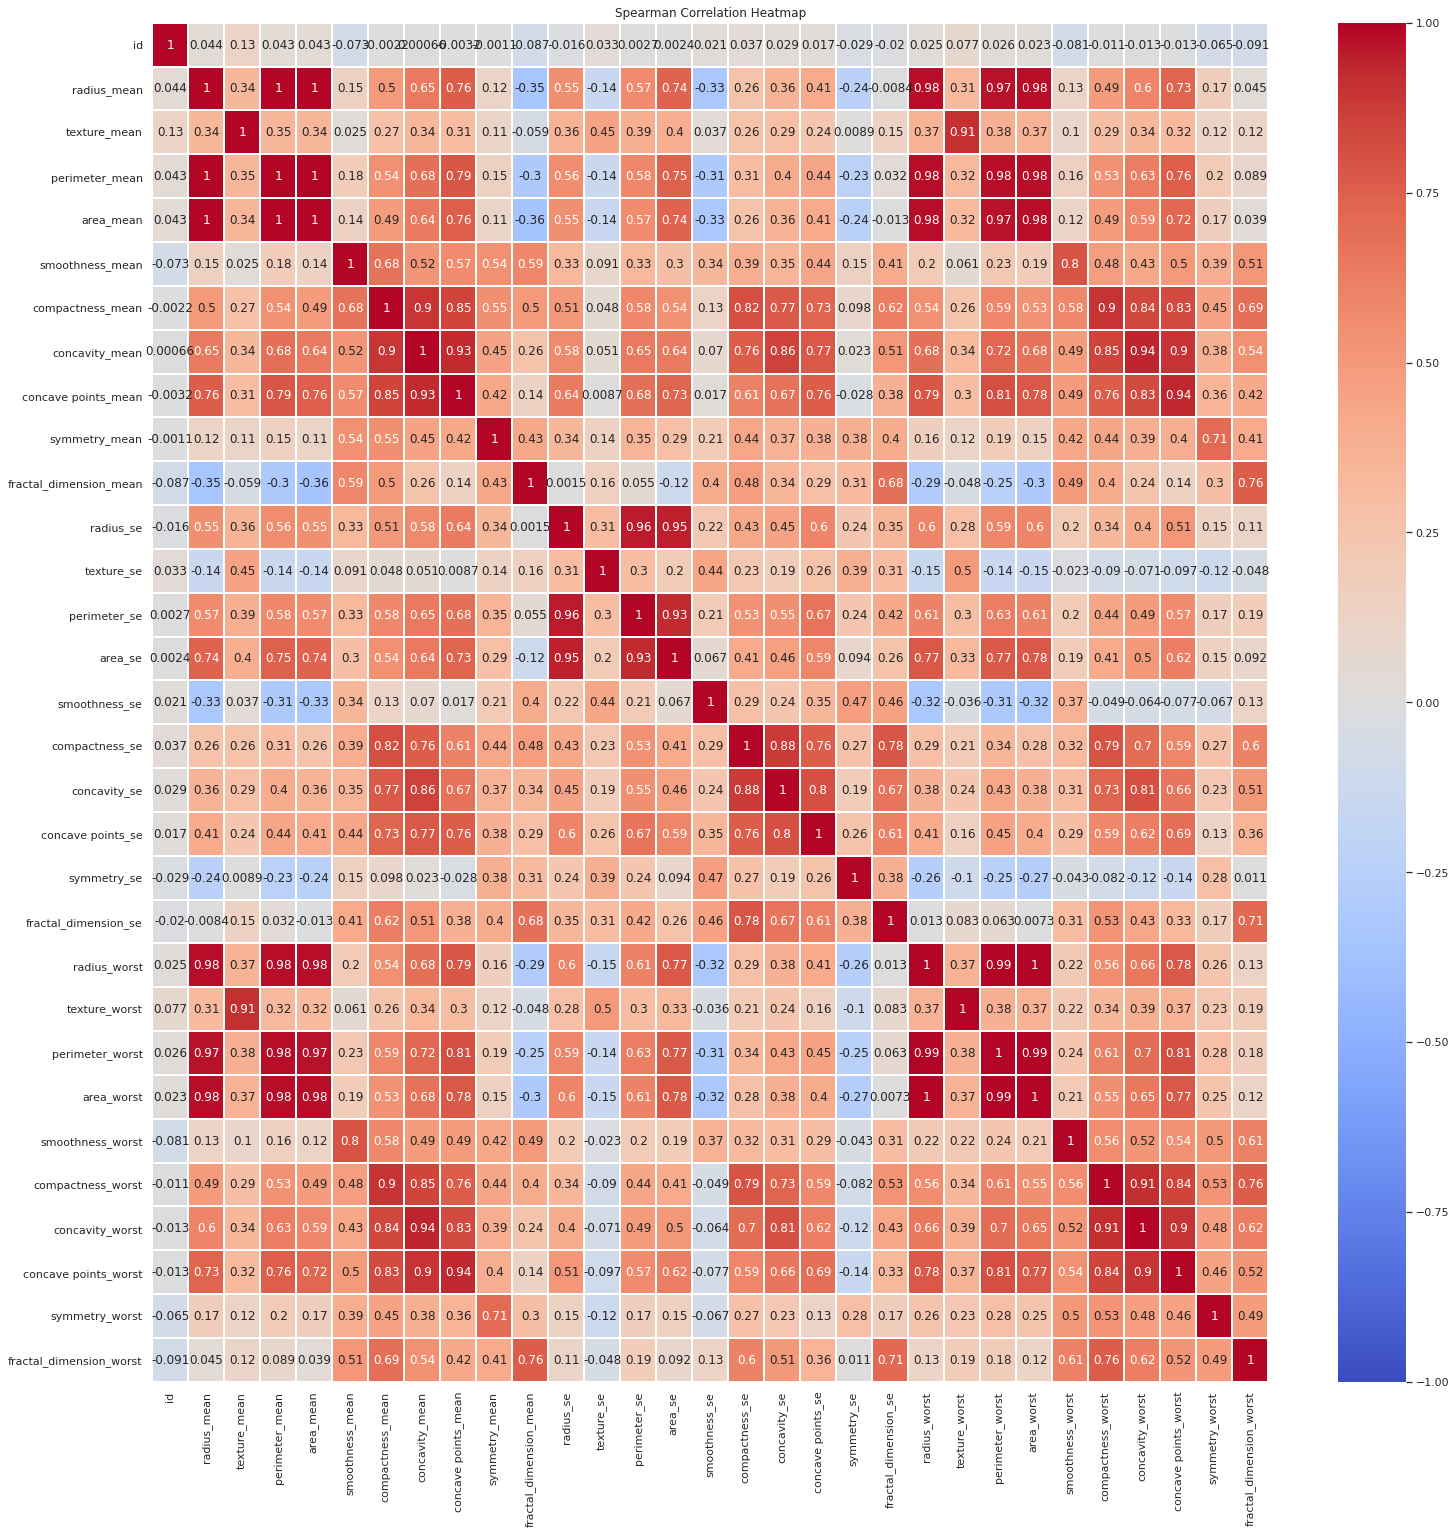

In [33]:
# check correlation
# Pearson Correlation
plt.figure(figsize=(25,25))
plt.title("Pearson Correlation Heatmap")
corr = df.corr(method='pearson')
mask = np.tril(df.corr())
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot = True, # to show the correlation degree on cell
           vmin=-1,
           vmax=1,
           center= 0,
           fmt='0.2g', #
           cmap= 'coolwarm',
           linewidths=1, # cells partioning line width
           linecolor='white', # for spacing line color between cells
           square=False,#to make cells square 
           cbar_kws= {'orientation': 'vertical'}
           )

b, t = plt.ylim() 
b += 0.00001 
t -= 0.00001
plt.ylim(b,t) 
plt.show()

################################################################################
plt.figure(figsize=(25,25))
plt.title("Spearman Correlation Heatmap")
corr = df.corr(method='spearman')
mask = np.tril(df.corr())
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot = True, # to show the correlation degree on cell
           vmin=-1,
           vmax=1,
           center= 0,
           fmt='0.2g', #
           cmap= 'coolwarm',
           linewidths=1, # cells partioning line width
           linecolor='white', # for spacing line color between cells
           square=False,#to make cells square 
           cbar_kws= {'orientation': 'vertical'}
           )

b, t = plt.ylim() 
b += 0.00001  
t -= 0.00001  
plt.ylim(b,t) 
plt.show()

As one can see from both correlation plots, there are very strong correlations, between radius_mean, perimeter_mean, area_mean, radius_worst, perimeter_worst, area_worst.

In addition, there are strong correlations between compactness_mean, compactness_worst, concavity_worst, concave_points_worst, concavity_se, compactness_se, concave_points_se.

Thus, it is reasonable to assume that our feature matrix can potentially benefit from a dimensionality reduction.

### Comparing Feature Values by Groups

It is also worth exploring whether there is a difference in the values of different variables, if split by diagnosis.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


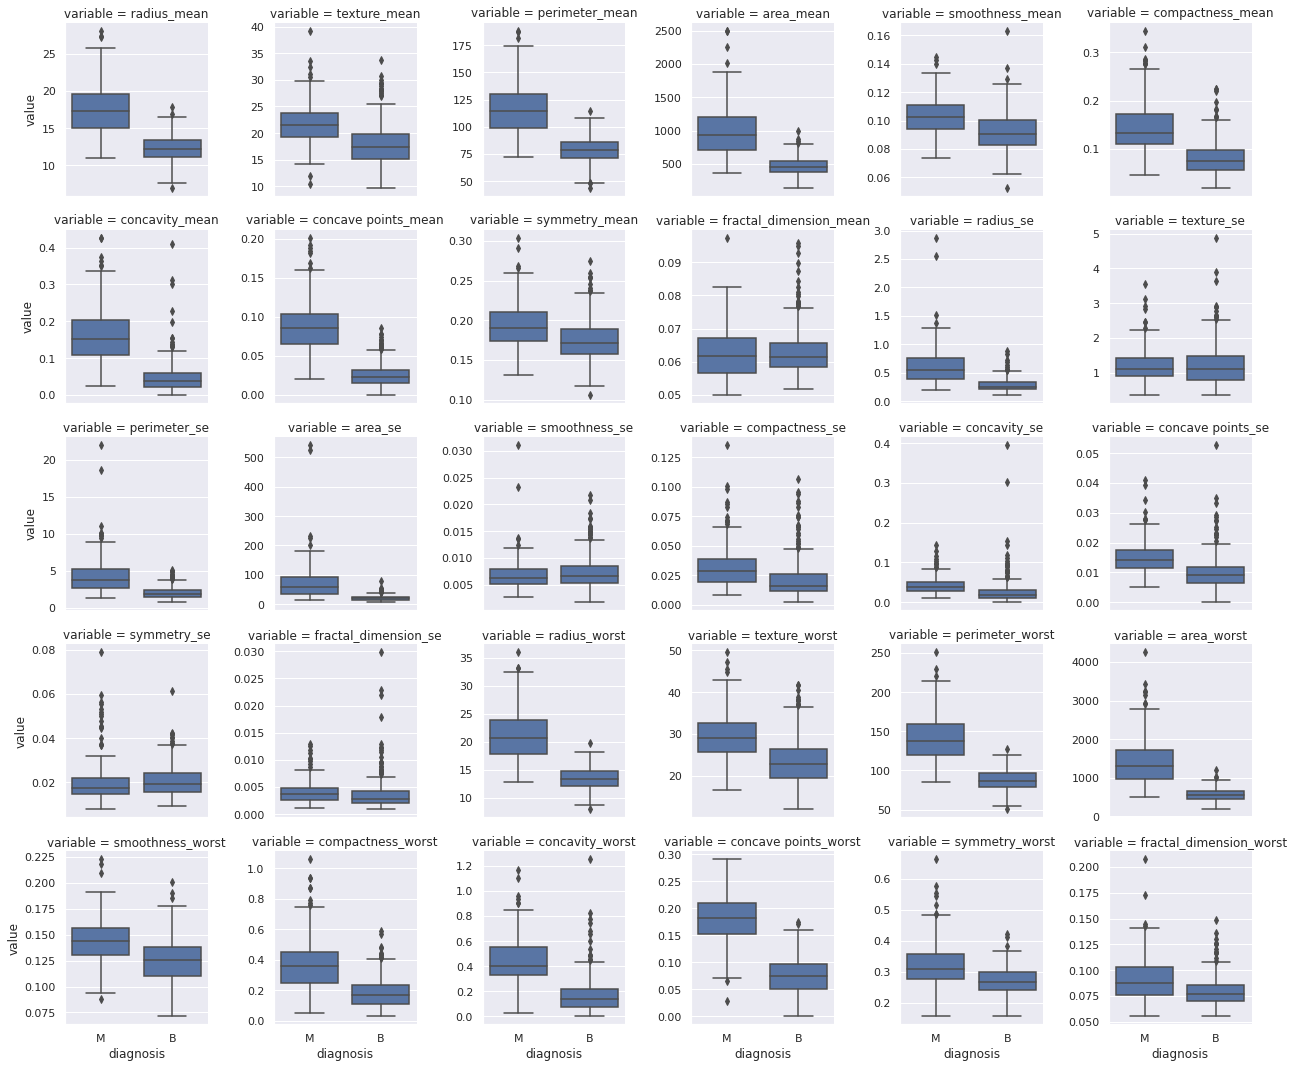

In [34]:
df_plot = df.melt(id_vars=['id', 'diagnosis'])
cols = df.columns
grid = sns.axisgrid.FacetGrid(df_plot[df_plot.variable.isin(cols)], col='variable', sharey=False, col_wrap = 6)
grid.map(sns.boxplot, 'diagnosis','value')

As one can see, for most variables, when their values across samples are grouped by diagnosis, there appears to be a difference in the means, suggesting that these variables are potentially informative as features.

For several variables - symmetry_se, fractal_dimensions_se, texture_se, smoothness_se, at least at visual inspection, there doesn't appear to be a significant difference in the means between groups, which could potentially mean that these are not very informative as features.

Exploratory Data Analysis gave us some interesting insights about our dataset, which we could experiment with later on, when selecting features and improving our model.

### Checking Data Normality

Another step worth considering is inspecting whether the features are normally distributed. This would be useful when deciding whether to normalize or standardize the data.

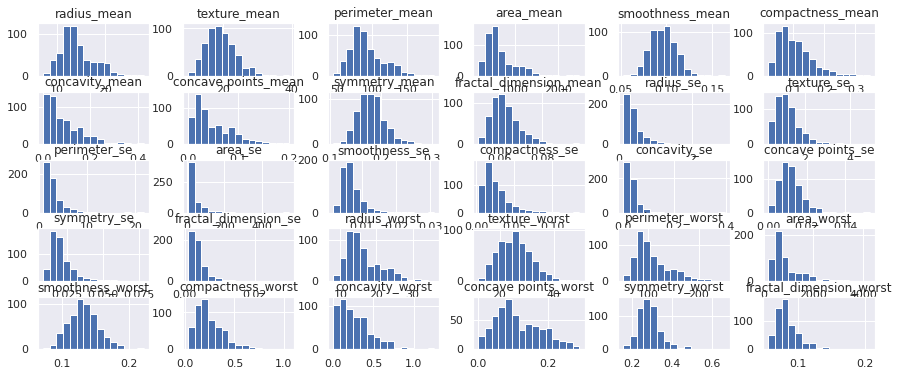

In [35]:
cols = df.columns[2:]
df[cols].hist(bins=15, figsize=(15, 6), layout=(5, 6));

As one can see, a significant proportion of the variables are not normally distributed, suggesting that it will be more reasonable to normalize, instead of standardize them.

## Splitting Dataset into Train and Test Set

In [36]:
# Extract Class Labels

y = df['diagnosis']
y.head()


0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [37]:
# Extract Features
# drop the label column and the id column
X = df.drop(columns=['diagnosis', 'id'])
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [38]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_test.head()


(426, 30)
(426,)
(143, 30)
(143,)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
468,17.60,23.33,119.00,980.5,0.09289,0.20040,0.21360,0.10020,0.1696,0.07369,0.9289,1.4650,5.801,104.90,0.006766,0.07025,0.06591,0.023110,0.01673,0.011300,21.57,28.87,143.60,1437.0,0.1207,0.4785,0.5165,0.19960,0.2301,0.12240
221,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.04451,0.1962,0.06303,0.2569,0.4981,2.011,21.03,0.005851,0.02314,0.02544,0.008360,0.01842,0.002918,14.98,17.13,101.10,686.6,0.1376,0.2698,0.2577,0.09090,0.3065,0.08177
93,13.45,18.30,86.60,555.1,0.10220,0.08165,0.03974,0.02780,0.1638,0.05710,0.2950,1.3730,2.099,25.22,0.005884,0.01491,0.01872,0.009366,0.01884,0.001817,15.10,25.94,97.59,699.4,0.1339,0.1751,0.1381,0.07911,0.2678,0.06603
240,13.64,15.60,87.38,575.3,0.09423,0.06630,0.04705,0.03731,0.1717,0.05660,0.3242,0.6612,1.996,27.19,0.006470,0.01248,0.01810,0.011030,0.01898,0.001794,14.85,19.05,94.11,683.4,0.1278,0.1291,0.1533,0.09222,0.2530,0.06510
128,15.10,16.39,99.58,674.5,0.11500,0.18070,0.11380,0.08534,0.2001,0.06467,0.4309,1.0680,2.796,39.84,0.009006,0.04185,0.03204,0.022580,0.02353,0.004984,16.11,18.33,105.90,762.6,0.1386,0.2883,0.1960,0.14230,0.2590,0.07779


## Data Normalization

As we already established, most of our numerical variables are not normally distirbuted, hence, normalization is the reasonable choice for data transformation. Normalization is necessary as sometimes when the features are on different scales, this could affect negatively the performance of algorithms. In this case we use sklearn's *MinMaxScaler*.

In [39]:
# Normalize each feature, by subtracting the mean of all samples for that feature and dividing by the std
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [40]:
# check that the proportion of M/(M + B) samples in both train and test set is rougly the same
# as there are less samples with label "M", which makes our dataset imbalanced.
y_train.describe()

count     426
unique      2
top         B
freq      267
Name: diagnosis, dtype: object

In [41]:
prop_train =  (y_train.describe()[0] - y_train.describe()[3])/y_train.describe()[0]
print('Proportion M/(B+M):', prop_train)

Proportion M/(B+M): 0.3732394366197183


In [42]:
y_test.describe()

count     143
unique      2
top         B
freq       90
Name: diagnosis, dtype: object

In [43]:
prop_test =  (y_test.describe()[0] - y_test.describe()[3])/y_test.describe()[0]
print('Proportion M/(B+M):', prop_test)

Proportion M/(B+M): 0.3706293706293706


## Model Fitting

### Hyperparameter Tuning Using GridSearchCV

In our prject we decided to use an SVM classifier for classifying breast tumours. In order to find the optimal parameters for the SVM, we start by using grid search with cross-validation, with the default of 5 folds. The sklearn GridSearchCV conducts stratified cross-validation by default, which solves the problem with our imbalanced dataset.


### Model Performance Metric

In order to evaluate the models generated by GridSearchCV, we decided to use a weighted F1-score. The reason for this is because in this case we want a balanced performance in both precision and recall and an F1-score is a good way to balance this. We chose the weighted option, as it works well for imbalanced dataset.

In [44]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [1e-4, 1e-2, 1, 5, 10],
                     'C': [1e-1, 1, 10, 100, 1000]},]

scoring = {'f1_weighted': make_scorer(f1_score, average='weighted')}
clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring = scoring, refit = 'f1_weighted')
clf.fit(X_train, y_train)
print("Best parameters set through GridSearchCV")
print()
print(clf.best_params_)

Best parameters set through GridSearchCV

{'C': 10, 'kernel': 'linear'}


Now that we have established the optimal set of parameters, we proceed to training the best model on the train set.

### Final Model

In [45]:
# Instantiating Best Model
clf = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.01)
clf.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Model Testing

In [46]:
# Test model on test set
X_test = scaler.transform(X_test)
y_pred = clf.predict(X_test)


In [47]:
# Calculate model performance metrics on test set

print("Weighted F1-Score")
print(f1_score(y_test, y_pred, average = "weighted"))
print()
print("Recall")
print(recall_score(y_test, y_pred, average = "weighted"))
print()
print("Precision")
print(precision_score(y_test, y_pred, average = "weighted"))
print()
print("Accuracy")
print(accuracy_score(y_test, y_pred))

Weighted F1-Score
0.9576753170103555

Recall
0.958041958041958

Precision
0.9589589741565424

Accuracy
0.958041958041958


It is also worth investigating whether our model performs better, compared to "all-benign-outcomes" scenario. 
In this case we will only calculate the accuracy measure, since precision and recall are less intuitive, since there are no "predictions" with value "M".

In [48]:
# Task5: Comparison to All-Zero (Benign) Prediction
y_zero = ["B"]*(len(y_test))
print(accuracy_score(y_test, y_zero))

0.6293706293706294


As one can see, compared to the accuracy score of our model, the accuracy if all outcomes are with value "B", is significantly lower.
Which suggests that our model is working well.

It seems like in this case an SVM classifier is an adequate choice for classifying breast cancer tumours. Since there is little room for improvement, judged by the standard classification metrics, no further experiments on the dataset will be explored.

**REFERENCES:**


[1] *Breast Cancer Wisconsin (Diagnostic) Data Set. (2020). Retrieved 5 November 2020, from https://www.kaggle.com/uciml/breast-cancer-wisconsin-data*